In [1]:
import re
import json
import random
import spacy
import numpy as np
import pandas as pd 
from glob import glob
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from textwrap import wrap
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px

from pymagnitude import *
from tqdm import tqdm 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pymagnitude/third_party/allennlp/common/params.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Ordere

In [2]:
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)
    
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

In [3]:
repr_df_files = glob("CSV_files/*.csv")

df = pd.DataFrame()

for repr_df_file in repr_df_files:
    repr_df = pd.read_csv(repr_df_file)
    df = df.append(repr_df[:950])

In [4]:
df.head()

ID_Article  communityId  ID_RelatedVenue  \
0     1874654        21349            11104   
1     2900992        21349            11104   
2     2923201        21349            11104   
3     2933659        21349            11104   
4      898097        21349             9078   

                                               title  year  \
0  Sea slicks and oil spills-the chemical structu...  2004   
1  Stability assessment of high-speed railway usi...  2016   
2  Active learning based autoencoder for hyperspe...  2016   
3  Canopy vertical parameters estimation using un...  2016   
4  Perceptron nonlinear blind source separation f...  2012   

                                            abstract  
0  The different morphology of palmitic acid metl...  
1  High-speed railways play important roles in co...  
2  In this paper, we joint autoencoder with activ...  
3  Canopy vertical parameters, such as tree heigh...  
4  In this paper, we aim to classify remotely sen...

In [5]:
df['communityId'].value_counts()

21220    950
22457    950
22736    950
21239    950
21246    909
21235    893
20178    855
21349    835
21212    787
21258    739
Name: communityId, dtype: int64

First, we will plot a graph of distribution of papers against the year it was presented in taking into account all papers of different communities collectively so that we know which years account for majority of the years presented in.

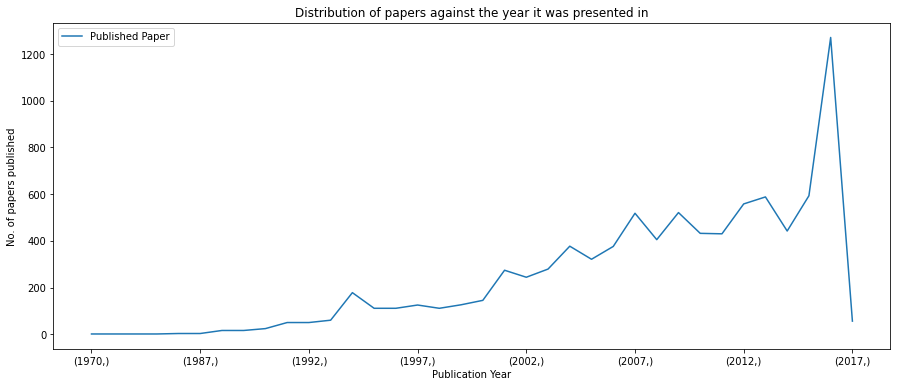

In [6]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot(figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was presented in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])
plt.show()

The above graph lets us know that most of the papers in our data is presented after the year 2000 with papers presented increasing as we move forward in years.

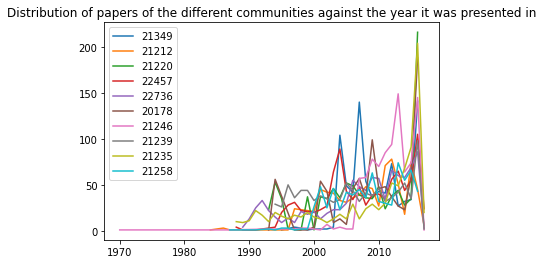

In [7]:
for comm in df.communityId.unique():
    to_plot = df[df['communityId'] == comm].sort_values(by='year')['year'].value_counts(sort=False)
    years = to_plot.index
    counts = to_plot.values
    plt.plot(years, counts, label = comm)

plt.title('Distribution of papers of the different communities against the year it was presented in')
plt.legend()
plt.show()

Above, we plot a distribution of all the papers against the year it was presented in for each individual community. We can observe that communities 21235, 21230 have a lot of papers that were presented recently.

Next, we will see which papers were presented in which conference. This will let us see if there are any conferences that are majorly common accross different communities.

In [8]:
confs = df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)['ID_RelatedVenue'].unique()

for conf in confs:
    print(f"{conf}: {conference_data_dict[conf]}")

11104: international geoscience and remote sensing symposium
9078: international conference on image processing
9099: acm multimedia
8228: international conference on communications
9616: international conference on pattern recognition
8502: workshop on applications of computer vision
23735: intelligent robots and systems
369: vehicular technology conference
8494: international symposium on circuits and systems
10228: wireless communications and networking conference
11470: international conference on multimedia and expo
30: international conference of the ieee engineering in medicine and biology society
21106: international conference on computer vision
8806: acm symposium on applied computing
9475: conference on decision and control
11321: international conference on machine learning
20358: international world wide web conferences
9896: conference on computer supported cooperative work
20561: hawaii international conference on system sciences
20332: national conference on artificial 

We will prepare abbreviations for the above conferences for better visualization of the distribution of papers across different conferences.

In [9]:
conf_abbvs = { 11104: 'IGRSS', 535: 'ASRUW', 256: 'ICLR', 9463: 'NACACL', 390: 'ISBI', 8960: 'NIPS', 8441: 'ACC', 65: 'RHIC', 11166: 'ICDM', 9804: 'CISCA', 422: 'KDDM', 20332: 'NCAI', 20561: 'HICSS', 9896: 'CCSCW', 20358: 'IWWWC', 11321: 'ICML', 9475: 'CDC', 8806: 'ASAC', 21106: 'ICCV', 30: 'ICEMBS', 11470: 'ICME', 10228: 'WCNC', 8494: 'ISCS', 369: 'VTC', 23735: 'IRS', 8502: 'WACV', 9616: 'ICPR', 8228: 'ICC', 9099: 'AM', 9078: 'ICIP' }

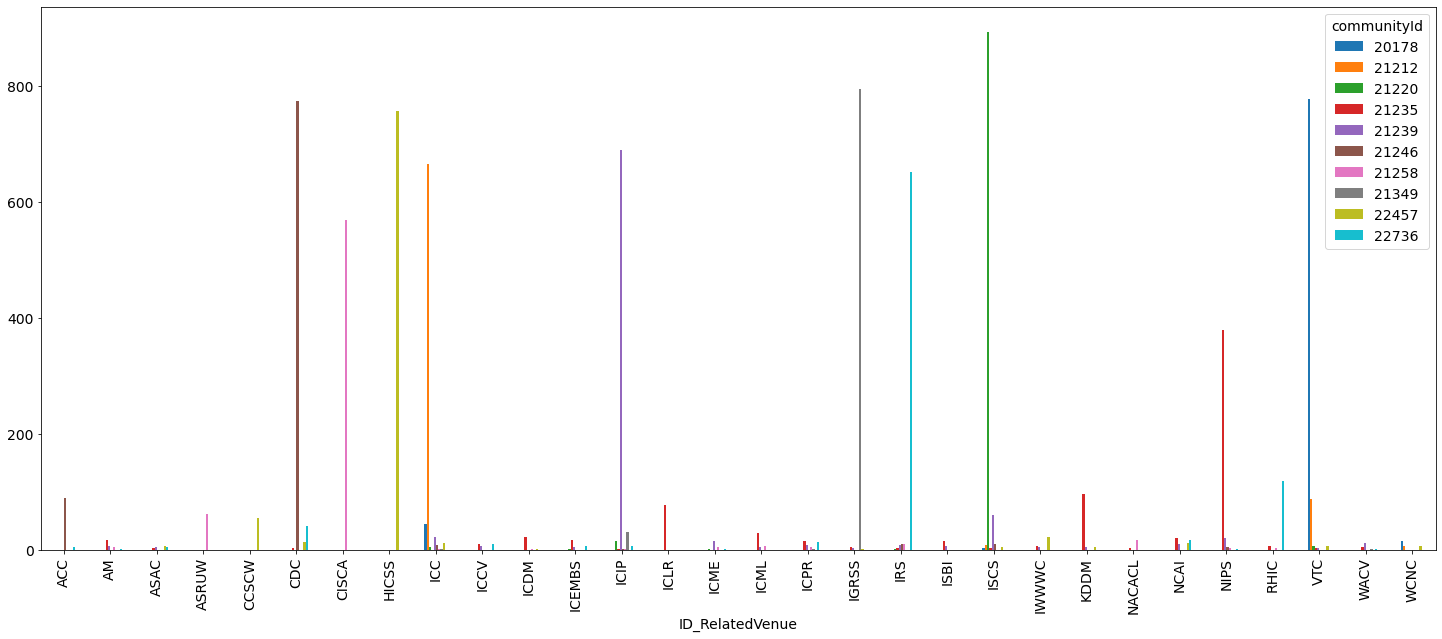

In [148]:
plot_df = df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)
plot_df['ID_RelatedVenue'] = plot_df['ID_RelatedVenue'].apply(lambda x: conf_abbvs[x])
results = pd.crosstab(plot_df['ID_RelatedVenue'], plot_df['communityId'])

plt.rcParams.update({'font.size': 14})
rcParams['figure.figsize'] = 25, 10
results.plot.bar()
plt.show()

From the bar graph visualization above, we can observe that majority of papers in each community were presented dominantly in a single conference. For each of the differently colored lines, we see that each of them has a tall height in a particular conference venue. This helps us understand that conference venue might be a major factor for allocation of a paper to a particular community.

For analyzing the papers across different communites, we will use only the titles of the each of the papers. We can use the paper abstracts as well but that doesn't seem to make much of a difference to the results which we found out when analyzing each of the communities individually. Also, it saves memory footprint and makes everything easier to visualize.

In [167]:
plot_df = pd.DataFrame()
stop_words.update(['based', 'using', 'A', 'The', 'system', 'algorithm'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
plot_df['communityId'] = df['communityId']

In [12]:
df

ID_Article  communityId  ID_RelatedVenue  \
0       1874654        21349            11104   
1       2900992        21349            11104   
2       2923201        21349            11104   
3       2933659        21349            11104   
4        898097        21349             9078   
..          ...          ...              ...   
734     1286721        21258              535   
735     2906891        21258             9078   
736     1151681        21258             8228   
737     1979387        21258              535   
738      943129        21258              235   

                                                 title  year  \
0    Sea slicks and oil spills-the chemical structu...  2004   
1    Stability assessment of high-speed railway usi...  2016   
2    Active learning based autoencoder for hyperspe...  2016   
3    Canopy vertical parameters estimation using un...  2016   
4    Perceptron nonlinear blind source separation f...  2012   
..                                                 ...   ...   
734  Barge-in effects in Bayesian dialogue act reco...  2013   
735  Machine listening techniques as a complement t...  2016   
736  Same but different? — Using speech signal feat...  2012   
737                 Dynamic network decoding revisited  2009   
738  Example-based speech intention understanding a...  2002   

                                              abstract  
0    The different morphology of palmitic acid metl...  
1    High-speed railways play important roles in co...  
2    In this paper, we joint autoencoder with activ...  
3    Canopy vertical parameters, such as tree heigh...  
4    In this paper, we aim to classify remotely sen...  
..                                                 ...  
734  Dialogue act recognition and simulation are tr...  
735  Video is now one of the major sources of infor...  
736  In this paper we demonstrate how speech signal...  
737  We present a dynamic network decoder capable o...  
738  This paper proposes a method of speech intenti...  

[8818 rows x 6 columns]

### Top 15 Words Distribution across Communities

Here we will plot a visualization for distribution of the top 15 words from all the paper titles text across the different communities. Each of the 15 words will be represented by a bar and distribution across communities for that word will be colored depending on the frequency of the word in a particular community.

In [170]:
top_15_words = pd.Series(' '.join(plot_df['col']).split()).value_counts()[:15].index.to_list()

community_word_freqs = list()
for word in top_15_words:
    word_freq_list = list()
    for communityId in plot_df['communityId'].unique():
        df_ = plot_df[plot_df['communityId'] == communityId]
        word_freq_list.append(df_.col.str.count(word).sum())
    community_word_freqs.append(word_freq_list)
    
df_list, cols = list(), list()

for word, counts in zip(top_15_words, community_word_freqs):
    df_list.append([word] + counts)

cols = ['Word'] + [community for community in plot_df['communityId'].unique()]

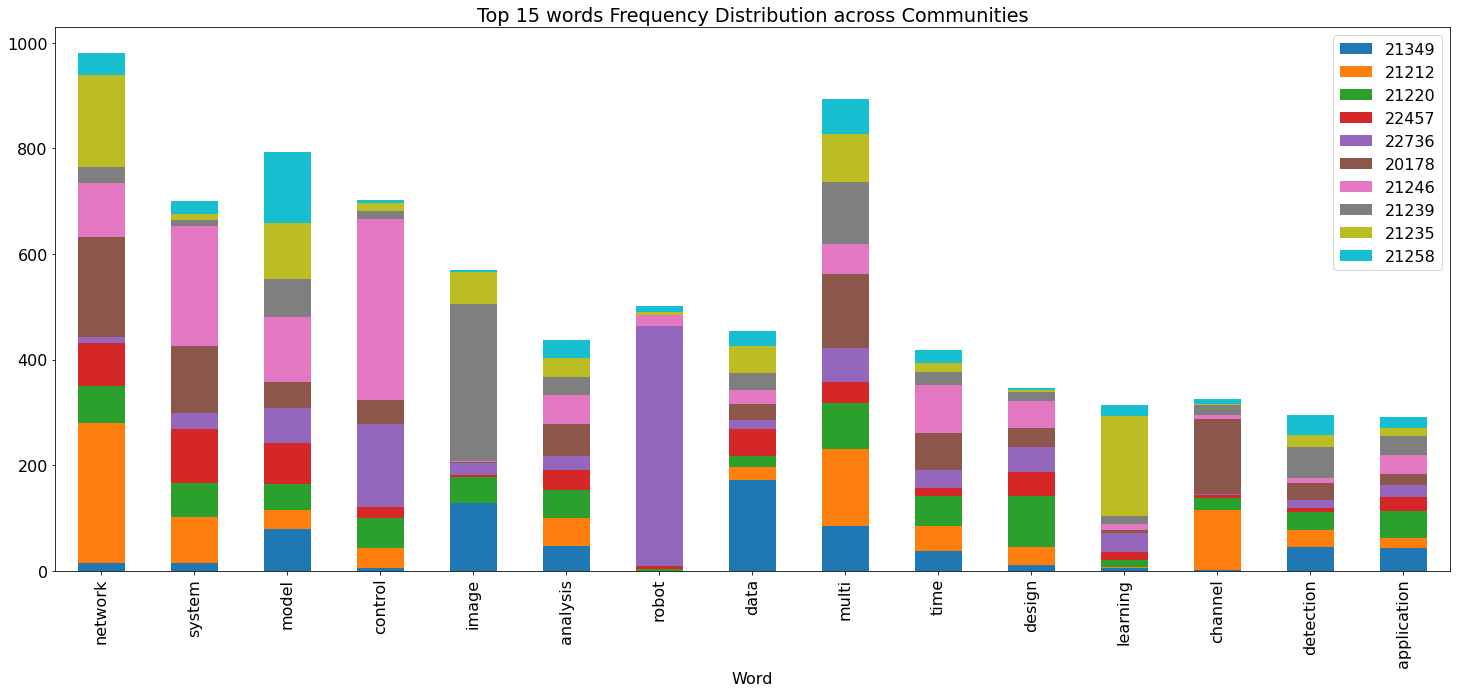

In [171]:
freq_df = pd.DataFrame(df_list, columns=cols)
plt.rcParams.update({'font.size': 16})
freq_df.plot(x='Word', kind='bar', stacked=True,
        title='Top 15 words Frequency Distribution across Communities')
plt.show()

### Wordcloud Visualization

We will plot wordclouds for each of the communities we have so that we can visualize and see which are the most common terms and words that appear in the titles of the papers. By looking at the wordclouds of each communities itself, we can get a basic idea of what the papers in that community talk about. Since there are a lot of terms that frequently appear in the paper titles, they will be easily discernible since the fontsize of the terms will be bigger as compared to the other terms. Also, since we have already eliminated all stopwords from titles, the unimportant and non-contributing terms of title text will be removed.

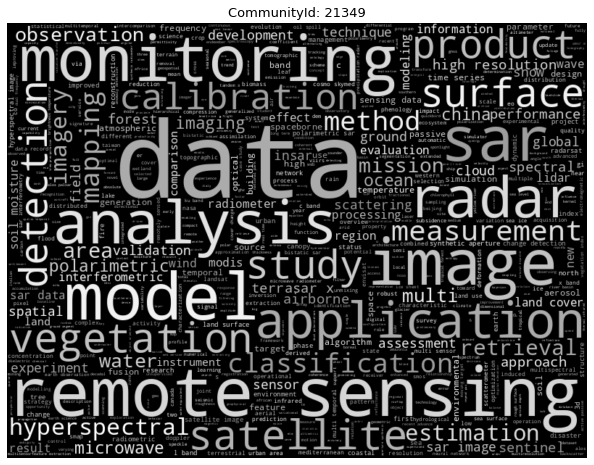

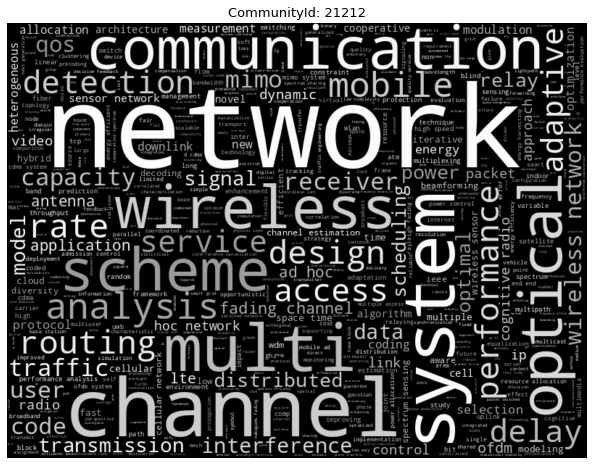

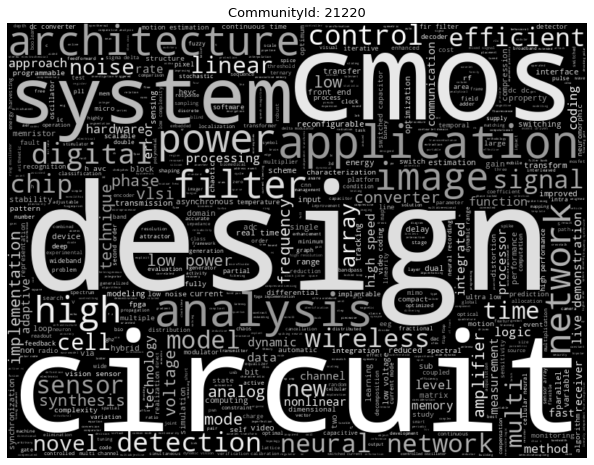

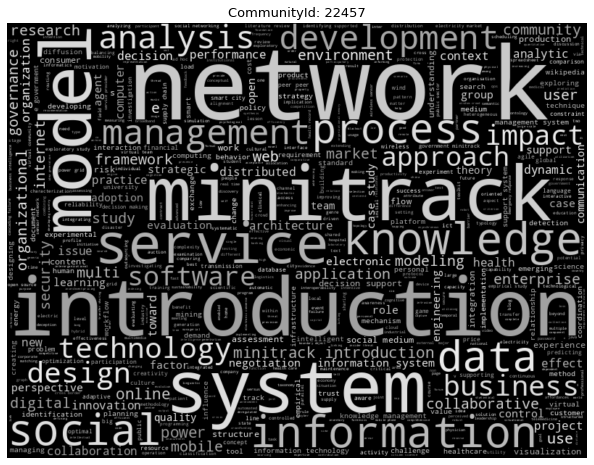

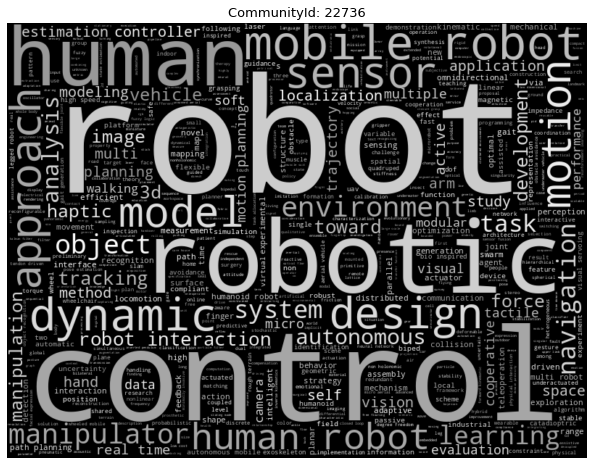

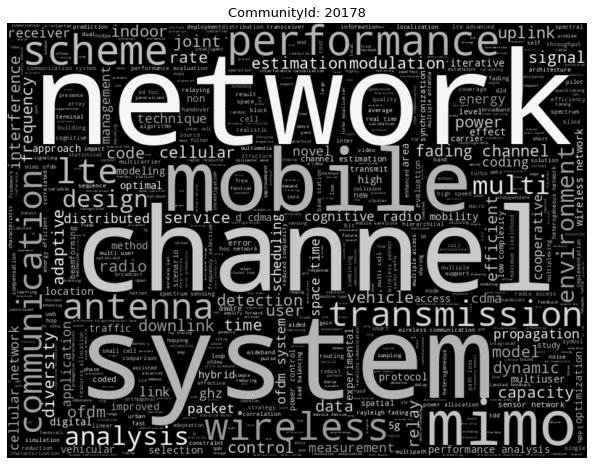

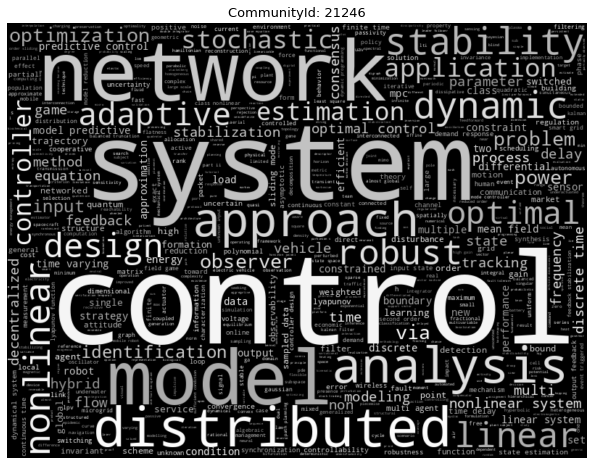

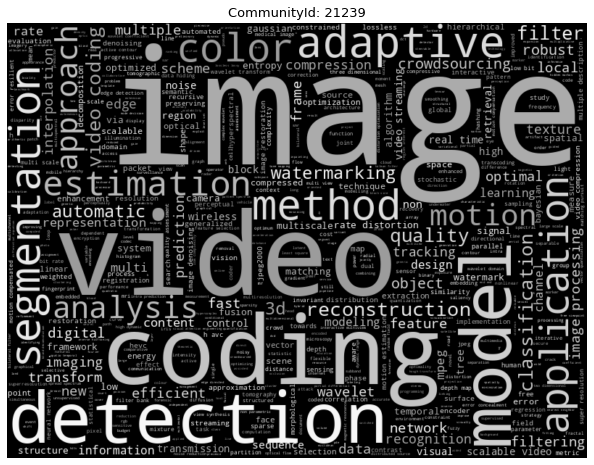

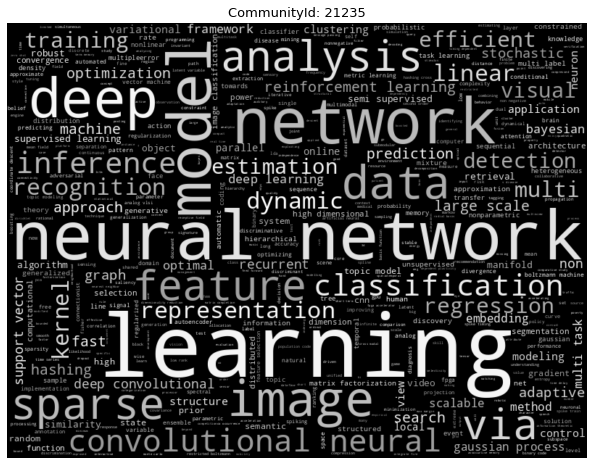

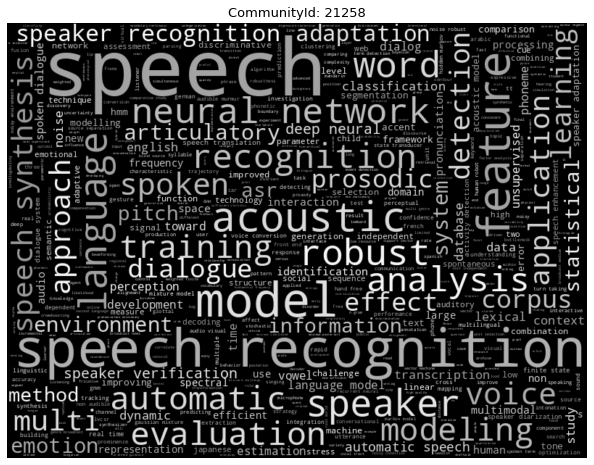

In [80]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Function for generating word clouds
def generate_wordcloud(data, communityId):
    wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words.update([]), width=800, height=600)
    wc.generate(" ".join(word_data))
    wc.recolor(color_func=grey_color_func, random_state=17)
    plt.figure(figsize=(15,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap('CommunityId: ' + str(communityId),60)),fontsize=13)
    plt.show()

# Plotting word cloud for each communityId
for communityId in plot_df['communityId'].unique():
    word_data = plot_df[plot_df['communityId'] == communityId]['col'].values
    generate_wordcloud(word_data, communityId)

## Visualizing titles of the papers in 2 dimensional and 3 dimensional space through t-SNE

Next we will visualize all the titles across the different communities by mapping [fasttext](https://fasttext.cc/) embeddings of the title of the papers onto 2-D space using [t-SNE](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1). t-SNE is a tool that can be used to visualize high-dimensional data by reducing the dimensions of the data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

This visualization will help us look how different each of the papers in the different communities are. For vectorizing, we use a library called pymagnitude. Its easy to set up and requires minimal code for vectorization. Initially, we only vectorize the each of the words in the text and take the weighted average of each of the words to produce the final 300 dimensional vector. Weightages to be given to each word is generated through Inverse Document Frequency scores. The IDF is a measure of whether a term is common or rare in a given document corpus. It is obtained by dividing the total number of documents by the number of documents containing the term in the corpus.

**NOTE:** To run the vectorization, please download the .magnitude file from the link provided and place it inside a 'vectors' directory with the 'vectors' directory in the same root directory as the notebook.

In [13]:
# curl -O http://magnitude.plasticity.ai/fasttext/medium/wiki-news-300d-1M-subword.magnitude
fasttext = Magnitude("vectors/wiki-news-300d-1M-subword.magnitude")
idf_dicts = dict()

for comm in df['communityId'].unique():
    tfidf = TfidfVectorizer()
    tfidf.fit(plot_df[df['communityId'] == comm]['col'].values)
    idf_dicts[comm] = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [14]:
def tfidf_fasttext(df):
    vectors = []
    for title, comm in tqdm(zip(df.title.values, df.communityId.values)):
        fasttext_vectors = fasttext.query(word_tokenize(title))
        weights = [idf_dicts[comm].get(word, 1) for word in word_tokenize(title)]
        vectors.append(np.average(fasttext_vectors, axis = 0, weights = weights))
    return np.array(vectors)

vectors = tfidf_fasttext(df)

8818it [02:04, 71.02it/s] 


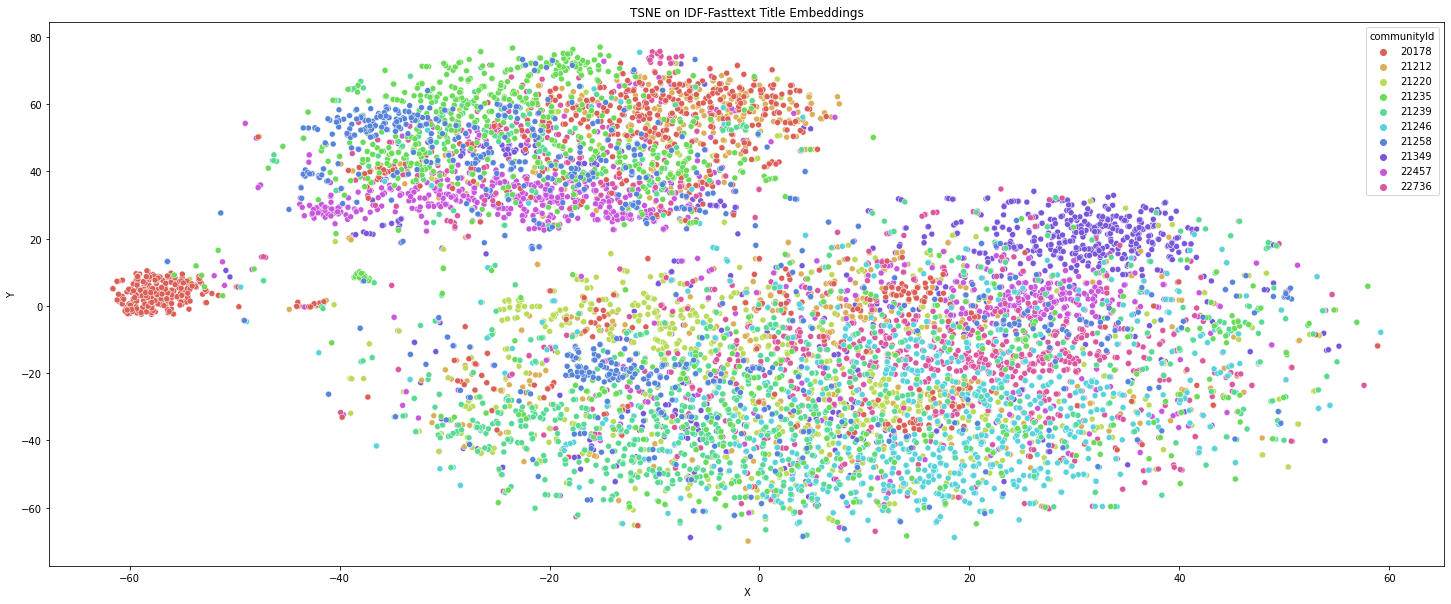

In [15]:
tsne_2d = TSNE(n_components = 2, n_jobs= -1, verbose = 0, perplexity = 30)
tsne_data_2d = tsne_2d.fit_transform(vectors)

tsne_data_2d = pd.DataFrame(tsne_data_2d, columns = ['X', 'Y'])
tsne_data_2d['communityId'] = df['communityId'].values

sns.scatterplot(x = 'X', y = 'Y', hue='communityId', palette=sns.color_palette("hls", 10), data=tsne_data_2d)
plt.title('TSNE on IDF-Fasttext Title Embeddings')
plt.show()

From the scatter plot plotted above with the help of t-SNE reduction technique, we can see how the title embeddings vary across the different communities. Some of the papers of communities like 22736 are very closely grouped together. While some others are scattered throughout the 2-D vector space. It definitely makes sense because even though papers belong to different communities, they have a lot of common terms and words in their titles. Terms like neural network, algorithm, data are very common which might be one of the factors that contribute to the overlapping of papers of different communities.

Next we will visualize the same vectors on a 3-D vector space.

In [79]:
tsne_3d = TSNE(n_components = 3, n_jobs= -1, verbose = 0, perplexity = 30)
tsne_data_3d = tsne_3d.fit_transform(vectors)

tsne_data_3d = pd.DataFrame(tsne_data_3d, columns = ['X', 'Y', 'Z'])
tsne_data_3d['communityId'] = df['communityId'].values
tsne_data_3d['communityId'] = tsne_data_3d['communityId'].astype('str')
tsne_data_3d = tsne_data_3d.drop([5951], axis='index') # Removing an outlier which affects the visualization of the plot

fig = px.scatter_3d(tsne_data_3d, x='X', y='Y', z='Z', color='communityId', 
                    color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_traces(marker={'size': 3})

fig.show()